## AdamW benchmarking

This is to benchmark an implementation of https://arxiv.org/abs/1711.05101

In [1]:
PATH = "/home/as/datasets/fastai.dogscats/"

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import matplotlib.pyplot as plt
%matplotlib inline

### Common stuff for all experiments

In [4]:
def Get_SGD_Momentum(momentum=0.9):
    return lambda *args, **kwargs: optim.SGD(*args, momentum=momentum, **kwargs)

def Get_Adam():
    return lambda *args, **kwargs: optim.Adam(*args, **kwargs)

In [5]:
import pickle

def save_list(fname, l):
    with open(fname, "wb") as fp:
        pickle.dump(l, fp)
        
def read_list(fname):
    with open(fname, "rb") as fp:
        return pickle.load(fp)

### This is a common function which does the training. 

The only thing it asks for is the optimizer, and the initial LR for that optimizer. Hence we are comparing optimizers keeping all things same.

In [6]:
def experiment(optimizer, PATH, lr=1e-3, find_lr=False, use_wd_schedule=False, wds=None, do_unfreeze=False):
    sz = 224
    bs = 24
    arch=resnet152
    cycle_len=2
    cycle_mult=2
    num_cycles = 4
    lr = lr
    
    if wds is None:
        weight_decay = 0.025 # As used in the paper https://arxiv.org/abs/1711.05101
    else:
        weight_decay = wds
    
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
    learn = ConvLearner.pretrained(arch, data, precompute=True, xtra_fc=[1024, 512], opt_fn=optimizer)
    
    if find_lr:
        lrf=learn.lr_find()
        learn.sched.plot()
        return
    
        
    learn.fit(lr, 1, wds=weight_decay, use_wd_schedule=use_wd_schedule)
    print('Now with precompute as False')
    if do_unfreeze:
        learn.unfreeze()
    learn.precompute=False
    learn.fit(lr, num_cycles, wds=weight_decay, use_wd_schedule=use_wd_schedule, cycle_len=cycle_len, cycle_mult=cycle_mult)
    
    loss = learn.sched.losses
    fig = plt.figure(figsize=(10, 5))
    plt.plot(loss)
    plt.show()
    learn.sched.plot_lr()
    
    return learn.sched.losses

### SGDR with restarts

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 69%|██████▉   | 660/959 [00:06<00:02, 109.17it/s, loss=0.201] 
CPU times: user 11.5 s, sys: 3.22 s, total: 14.8 s            
Wall time: 11.4 s


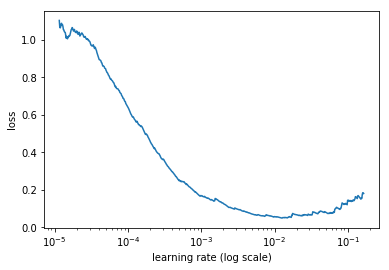

In [7]:
%%time
sgdm = Get_SGD_Momentum()
loss_sgdm = experiment(sgdm, PATH=PATH, find_lr=True)

In [ ]:
%%time
sgdm = Get_SGD_Momentum()
loss_sgdm = experiment(sgdm, PATH=PATH, lr=1e-2)
save_list('sgdm_loss.txt', loss_sgdm)

In [ ]:
%%time
sgdmw = Get_SGD_Momentum()
loss_sgdmw = experiment(sgdmw, PATH=PATH, lr=1e-2, use_wd_schedule=True)
save_list('sgdmw_loss.txt', loss_sgdmw)

### Vanilla Adam with fixed weight decay and restarts

In [ ]:
adam = Get_Adam()
loss_adam = experiment(adam, PATH, find_lr=True)

**Train**

In [ ]:
%%time
adam = Get_Adam()
loss_adam = experiment(adam, PATH, 1e-3)
save_list('adam_loss.txt', loss_adam)

In [ ]:
%%time
adamw = Get_Adam()
loss_adamw = experiment(adamw, PATH, 1e-3, use_wd_schedule=True)
save_list('adamw_loss.txt', loss_adamw)

In [ ]:
fig=plt.figure(figsize=(15, 10))
plt.plot(loss_adam, c='red', label='Adam')
plt.plot(loss_sgdm, c='blue', label='SGDM')
plt.plot(loss_adamw, c='green', label='AdamW')
plt.plot(loss_sgdmw, c='black', label='SGDW')
plt.legend()
plt.show()

### Differential Learning and Weight Decay

In [ ]:
%%time
adamw_diff = Get_Adam()
lr = 1e-3
wd = 0.025
loss_adamw_diff = experiment(adamw_diff, PATH, [lr/10, lr/5, lr], wds=[wd/10, wd/5, wd], use_wd_schedule=True)
save_list('loss_adamw_diff.txt', loss_adamw_diff)

In [ ]:
%%time
sgdw_diff = Get_SGD_Momentum(0.9)
lr = 1e-2
wd = 0.025
loss_sgdw_diff = experiment(sgdw_diff, PATH, [lr/10, lr/5, lr], wds=[wd/10, wd/5, wd], use_wd_schedule=True)
save_list('loss_sgdw_diff.txt', loss_sgdw_diff)

In [ ]:
"""
adamw = Get_AdamW()

sz = 32
bs = 64
PATH = "/home/as/datasets/fastai.dogscats"
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

learn_adam = ConvLearner.pretrained(arch, data, precompute=True, opt_fn=adamw)
lrf=learn_adam.lr_find()
learn_adam.sched.plot()

lr = 1e-3
wds=0.025
cycle_len=1
cycle_mult=1
num_cycles = 1

data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
learn_adam = ConvLearner.pretrained(arch, data, precompute=True, opt_fn=adamw
                                   )
learn_adam.fit(lr, 1, wds=wds)
print('Now with precompute as False')
learn_adam.precompute=False
learn_adam.fit(lr, num_cycles, wds=wds, cycle_len=cycle_len, cycle_mult=cycle_mult)
"""